# Create frequent public transport stops analysis - Phoenix, Arizona


This notebook describes a process to retain public transit stops points with frequent service using two methods.

## Method 1: Stop headway analysis using maxi interdeparture time
- identify stops with inter-departure time/headway less than or equal to 30 minutes within a specific time range;
- modified based on the [headway function](https://github.com/UDST/urbanaccess/blob/9c0f64faf63bae6f5a73ae23409ca68b28113026/urbanaccess/gtfs/headways.py) for stop level analysis

## Method 2: Stop headway analysis using average frequencies of departure

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)



### Notes:

- Input data format, including which tables, which columns, which order and handling of nulls - you'll need to customise this for each city.  A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt).

- GTFS feeds sourced in same season (?) and school term
    - we have vastly different climates across our cities --- so should perhaps aim for Spring? if we chose arbitrary feeds, some in winter and some in summer, our different cities could have vastly different conditions (particularly the snowy ones)
- Week days (Monday to Friday)
    - Day time (7am to 7pm (peak hour: 7am to 9am); as travel during day is important for different segments of community)
 
- We may need to consider details of how headway is operationalised (ie. spot checks do the results look reasonable, and if not how do we deal with it?  this is why I took the maximum headway of the two directions as it at the time seemed a simple and reasonable approach to recognise that a stop need only be frequently serviced in one direction - which is not literally interpreted as 'direction on the road', its do with the route itself.  There may be other methods to consider.)

Previous working branch:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  
https://github.com/shiqin-liu/global-indicators/blob/f86f4c2ca068a61f9f2621351f1ce9bbf4b04d88/process/07_create_public_transport_points.ipynb

In [214]:
#conda install -c udst urbanaccess
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

In [3]:
#conda install geopandas=0.6.3 -c conda-forge


In [219]:
import pandas as pd
import pandana as pdna
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [5]:
gpd.__version__ # UrbanAccess required earlier version of geopandas


'0.6.3'

In [6]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [211]:
# specified the folder path when GTFS date stores
GTFS = {'phoenix': {'gtfs_folder' : 'data/Transport',
                    'gtfs_url' : 'https://transitfeeds.com/p/valley-metro/68/20190705/download',
                    'gtfs_provider' : 'Phx Valley metro',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20190403', 
                    'end_date_mmdd' : '20190418',
                    # get bounding box from study region boundary shapefile
                    # bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
                    # you can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.
                    'bbox' : (-113.3338,32.505,-111.0399,34.0481), 
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'rail':{'route_types': 0, 
                                'peak_hour' : ['07:00:00', '09:00:00'],
                                'day_hour' : ['07:00:00', '19:00:00'],
                                'intervals': 30},
                        'bus' : {'route_types': 3,
                                  'peak_hour' : ['07:00:00', '09:00:00'], 
                                  'day_hour' : ['07:00:00', '19:00:00'],
                                  'intervals': 30}
                    } 
                   }
       }




# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Downloading GTFS data
- Loading GTFS data into a UrbanAccess transit data object
- conduct heaway analysis using maxi interdeparture time method


Load the GTFS feeds (currently a series of text files stored on disk) into a combined network of Pandas DataFrames.

- You can specify one feed or multiple feeds that are inside a root folder using the `gtfsfeed_path` parameter. If you want to aggregate multiple transit networks together, all the GTFS feeds you want to aggregate must be inside of a single root folder.
- Turn on `validation` and set a bounding box with the `remove_stops_outsidebbox` parameter turned on to ensure all your GTFS feed data are within a specified area.


In [151]:
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=gtfs_folder,
                                           validation=True,
                                           bbox=GTFS['phoenix']['bbox'],
                                           remove_stops_outsidebbox=True,
                                           append_definitions=True)


GTFS text file header whitespace check completed. Took 7.30 seconds
--------------------------------
Processing GTFS feed: gtfs
The agency.txt or agency_id column was not found. The unique agency id: gtfs was generated using the name of the folder containing the GTFS feed text files.
Unique agency id operation complete. Took 0.23 seconds
Unique GTFS feed id operation complete. Took 0.01 seconds
Records: {}
     stop_id  stop_code        stop_name  stop_desc   stop_lat    stop_lon  \
7800    9730    17112.0  2nd Av & 5th St        NaN  32.382707 -112.872186   

      zone_id  stop_url  location_type parent_station unique_agency_id  \
7800      NaN       NaN              0            NaN             gtfs   

     unique_feed_id  
7800         gtfs_1  
Removed identified stops that are outside of bounding box.
gtfs GTFS feed stops: coordinates are in northwest hemisphere. Latitude = North (90); Longitude = West (-90).
Appended route type to stops
Appended route type to stop_times
--------

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

In [152]:
#loaded_feeds.stops.head()


Quickly view the transit stop locations

In [153]:
#loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Calculate stop level headways
- Calculate headways for the AM Peak time period 
- the original UrbanAccess function calculates the stop and route level headway, it was revised to conduct only the stop level headway analysis.
Check here for the original [function](https://github.com/UDST/urbanaccess/blob/9c0f64faf63bae6f5a73ae23409ca68b28113026/urbanaccess/gtfs/network.py#L192)

## Select trips that run on weekdays 

In [154]:
# this module was downloaded (unchanged) from 
# https://github.com/UDST/urbanaccess/blob/9c0f64faf63bae6f5a73ae23409ca68b28113026/urbanaccess/gtfs/network.py
import ua_network

input_trips_df = loaded_feeds.trips
input_calendar_df = loaded_feeds.calendar
input_calendar_dates_df = loaded_feeds.calendar_dates
weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
# Select trips that run on specific day, here we are targeting normal weekdays, 

# select all trips that operate on monday based on service_id in calendar dates, unchanged based on the original functions
calendar_selected_trips_df = ua_network._trip_schedule_selector(input_trips_df, input_calendar_df,
                            input_calendar_dates_df, day='monday',
                            calendar_dates_lookup=None)
calendar_selected_trips_df = calendar_selected_trips_df.set_index(['service_id', 'route_id', 'trip_id', 'trip_headsign', 'direction_id', 
                   'block_id', 'shape_id','unique_agency_id', 'unique_feed_id'])

# iterate through weekdays to select all trips during weekdays
for day in weekdays:
    df = ua_network._trip_schedule_selector(input_trips_df, input_calendar_df,
                            input_calendar_dates_df, day=day,
                            calendar_dates_lookup=None)
    df = df.set_index(['service_id', 'route_id', 'trip_id', 'trip_headsign', 'direction_id', 
                   'block_id', 'shape_id','unique_agency_id', 'unique_feed_id'])
    calendar_selected_trips_df = pd.merge(calendar_selected_trips_df, df, 
                                       left_index=True, right_index=True, how='outer')
    
calendar_selected_trips_df = calendar_selected_trips_df.reset_index()

Using calendar to extract service_ids to select trips.
26 service_ids were extracted from calendar
15,882 trip(s) 29.36 percent of 54,102 total trip records were found in calendar for GTFS feed(s): ['gtfs']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
15,882 of 54,102 total trips were extracted representing calendar day: monday. Took 0.17 seconds
Using calendar to extract service_ids to select trips.
26 service_ids were extracted from calendar
15,882 trip(s) 29.36 percent of 54,102 total trip records were found in calendar for GTFS feed(s): ['gtfs']
NOTE: If you expected more trips to have been extract

In [155]:
# Interpolate missing stop times using a linear interpolator between known stop times
# unchanged based on the original function
loaded_feeds.stop_times_int = ua_network._interpolate_stop_times(
    stop_times_df=gtfsfeeds_dfs.stop_times,
    calendar_selected_trips_df=calendar_selected_trips_df,
    day='weekday')


There are no departure time records missing from trips following weekday schedule. There are no records to interpolate.


# Method 1: Stop headway analysis using maxi interdeparture time approach
- identify stops with inter-departure time/headway less than or equal to 30 minutes within a specific time range;
- modified based on the [headway function](https://github.com/UDST/urbanaccess/blob/9c0f64faf63bae6f5a73ae23409ca68b28113026/urbanaccess/gtfs/headways.py) for stop level analysis

In [156]:
# this module was downloaded from 
# https://github.com/UDST/urbanaccess/blob/9c0f64faf63bae6f5a73ae23409ca68b28113026/urbanaccess/gtfs/headways.py
# modified to conduct stop level analysis
import ua_headways

ua_headways.headways(loaded_feeds, GTFS['phoenix']['modes']['bus']['peak_hour'], 
                     route_type=GTFS['phoenix']['modes']['bus']['route_types'])


Stop times from 07:00:00 to 09:00:00 successfully selected 183,758 records out of 1,583,177 total records (11.61 percent of total). Took 0.69 seconds
Starting stop headway calculation for 7,707 stops...
stop headway calculation complete. Took 21.07 seconds
headway calculation complete. Took 23.23 seconds


In [251]:
# select maximum inter-departure time/headway less than or equal to 30 minutes
stop_30_mins_bus_headway = loaded_feeds.headways[loaded_feeds.headways['max'] <= 30
                                                ][['stop_id', 'max']].rename(columns={'max':'headway'})

stop_30_mins_bus = pd.merge(stop_30_mins_bus_headway, loaded_feeds.stops, how='left', on='stop_id')
len(stop_30_mins_bus)

6948

## Setup calender

- select valid service id based on weekdays, and start and end date
- this process is developed based on tidytransit [set_date_service_table](https://github.com/r-transit/tidytransit/blob/8a207aaf81482c268aa4bfc548c0697e24b5281c/R/time.R#L59) function

In [158]:
def get_date_weekday_df(start, end):
    """create table to show date and weekday of all dates from start to end date"""
    date_range = pd.date_range(start=start, end=end)
    dates = pd.DataFrame(date_range, columns=['date'])
    # Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
    weekdays = pd.DataFrame(date_range.weekday, columns=['weekday'])
    date_weekday_df = dates.join(weekdays)
    
    # replace weekday numeric to str values
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    date_weekday_df = date_weekday_df.replace([0, 1, 2, 3, 4, 5, 6], weekdays)
    return date_weekday_df

# tabulate each date and weekday from the start to the end date in calendar  
dates = get_date_weekday_df(start=str(min(loaded_feeds.calendar['start_date'])), 
                            end=str(max(loaded_feeds.calendar['end_date'])))



In [159]:
# gather services by weekdays
service_ids_weekdays = loaded_feeds.calendar[['service_id', 'start_date', 'end_date', 
                       'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'
                      ]].set_index(['service_id', 'start_date', 'end_date'
                                   ]).stack().to_frame().reset_index()

service_ids_weekdays = service_ids_weekdays[(service_ids_weekdays[0] == 1)
                                           ].rename(columns={'level_3':'weekday'}).drop(columns=[0])


In [167]:
# create table to connect every date to corresponding services (all dates from earliest to latest)
# set services to dates according to weekdays and start/end date
date_service_df = pd.merge(dates, service_ids_weekdays, on='weekday')

date_service_df['start_date'] = pd.to_datetime(date_service_df['start_date'], format='%Y%m%d')
date_service_df['end_date'] = pd.to_datetime(date_service_df['end_date'], format='%Y%m%d')


#filter valid service date within start and end date
date_service_df = date_service_df[(date_service_df['date'] >= date_service_df['start_date']) 
                & (date_service_df['date'] <= date_service_df['end_date'])][['date', 'weekday', 'service_id']]


In [168]:
# add calendar_dates additions (1) if the additional dates are within the start and end date range
addition_dates = loaded_feeds.calendar_dates[(loaded_feeds.calendar_dates['exception_type']==1)
                                            ][['service_id', 'date']]

min_start_datetime = pd.to_datetime(str(min(loaded_feeds.calendar['start_date'])))
max_end_datetime = pd.to_datetime(str(max(loaded_feeds.calendar['end_date'])))
addition_dates['date'] = pd.to_datetime(addition_dates['date'], format='%Y%m%d')
        
addition_dates['within_range'] = addition_dates['date'].apply(
    lambda x: 1 if (x >= min_start_datetime
                   ) & (x <= max_end_datetime) else 0)

addition_dates = addition_dates[addition_dates['within_range'] == 1][['service_id', 'date']]
date_service_df = pd.concat([addition_dates, date_service_df], ignore_index=True)

len(date_service_df), len(addition_dates)


(1277, 10)

In [169]:
# remove calendar_dates exceptions (2)
exception_dates = loaded_feeds.calendar_dates[(loaded_feeds.calendar_dates['exception_type']==2)
                                             ][['service_id', 'date']]

date_service_exception_df = pd.merge(exception_dates.set_index(['service_id', 'date']
                                  ), date_service_df.set_index(['service_id', 'date']), 
         left_index=True, right_index=True, indicator=True, how='outer').reset_index()

date_service_df = date_service_exception_df[(date_service_exception_df['_merge']=='right_only')
                                           ][['service_id', 'date', 'weekday']]

In [175]:
# limit within specified start and end date, within weekdays
start_date_mmdd = pd.to_datetime(GTFS['phoenix']['start_date_mmdd'], format='%Y%m%d')
end_date_mmdd = pd.to_datetime(GTFS['phoenix']['end_date_mmdd'], format='%Y%m%d')

date_service_df = date_service_df[~((date_service_df['weekday']=='saturday') | 
                                    (date_service_df['weekday']=='sunday'))
                                 ][(date_service_df['date'] >= start_date_mmdd) 
                                   & (date_service_df['date'] <= end_date_mmdd)]
len(date_service_df)

154

## Summarises the maximum number of days a stop_id could be a frequent stop by dow

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- Calculate the number of total normal weekdays during calendar start and end date  
- Calculate the number of weekdays that the frequent stop is in operation  
- Calculate the percentage of weekdays that each frequent stop is in operation, select those with 90% 

In [199]:
# filter valid service trips
valid_service_trips = pd.merge(date_service_df, calendar_selected_trips_df, on='service_id', how='left')

# filter stop times within the timerange
selected_interpolated_stop_times_df = ua_network._time_selector(
    df=loaded_feeds.stop_times_int, starttime=GTFS['phoenix']['modes']['bus']['peak_hour'][0],
    endtime=GTFS['phoenix']['modes']['bus']['peak_hour'][1])

# filter stops within valid service and time range 
stop_time_trips = pd.merge(valid_service_trips, selected_interpolated_stop_times_df, on='trip_id', how='inner')

# filter within route types
stop_time_trips = stop_time_trips[(stop_time_trips['route_type'] == GTFS['phoenix']['modes']['bus']['route_types'])]

Stop times from 07:00:00 to 09:00:00 successfully selected 183,758 records out of 1,583,177 total records (11.61 percent of total). Took 0.24 seconds


In [200]:
# merge to get stops within valid service and time range that are 30-min freqency stops
stop_30_mins_bus_dates = pd.merge(stop_30_mins_bus[['stop_id', 'headway', 'stop_name', 'stop_lat', 'stop_lon', 
                                              'parent_station', 'route_type',]], 
                                  stop_time_trips[['service_id', 'date', 'weekday', 'trip_id', 'direction_id', 'stop_id'
                                                  ]], on='stop_id', how='inner')

In [201]:
# Calculate the number of total normal weekdays during calendar start and end date
tot_weekdays = get_date_weekday_df(start=start_date_mmdd, end=end_date_mmdd)
weekdays_count = len(tot_weekdays[~((tot_weekdays['weekday']=='saturday') | 
                                    (tot_weekdays['weekday']=='sunday'))])
weekdays_count

12

In [234]:
# Calculate the number/pct of weekdays that the frequent stop is in operation
stop_30_mins_bus_weekday_count = stop_30_mins_bus_dates[[
    'stop_id', 'date', 'weekday']].drop_duplicates().groupby(['stop_id']).count()

stop_30_mins_bus_weekday_count['stop_pct_weekday'] = stop_30_mins_bus_weekday_count['weekday'] / weekdays_count


In [252]:
# Calculate the percentage of weekdays that each frequent stop is in operation, select those with 90%
stop_30_mins_bus_weekday_count = stop_30_mins_bus_weekday_count[stop_30_mins_bus_weekday_count['stop_pct_weekday'] > 0.9].reset_index()
stop_30_mins_bus_final_1 = pd.merge(stop_30_mins_bus_weekday_count, stop_30_mins_bus, on='stop_id', how='inner')

len(stop_30_mins_bus_final_1)

6761

# Method 2: Stop headway analysis using average departure time within the timeframe

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [204]:
# group by service date to get counts of departure of each stop of each direction
stop_time_trips_departure = stop_time_trips[['direction_id', 'stop_id', 'date', 'service_id'
                                  ]].groupby(['direction_id', 'stop_id', 'date']).agg(['count'])

stop_time_trips_departure.columns = ['departure']

In [205]:
# takes input start and end time range from 24 hour clock and converts
# it to seconds past midnight
# in order to select times that may be after midnight

# convert string time components to integer and then calculate seconds
# past midnight
# convert starttime 24 hour to seconds past midnight
start_h = int(str(modes['bus']['peak_hour'][0][0:2]))
start_m = int(str(modes['bus']['peak_hour'][0][3:5]))
start_s = int(str(modes['bus']['peak_hour'][0][6:8]))
starttime_sec = (start_h * 60 * 60) + (start_m * 60) + start_s

# convert endtime 24 hour to seconds past midnight
end_h = int(str(modes['bus']['peak_hour'][1][0:2]))
end_m = int(str(modes['bus']['peak_hour'][1][3:5]))
end_s = int(str(modes['bus']['peak_hour'][1][6:8]))
endtime_sec = (end_h * 60 * 60) + (end_m * 60) + end_s

# count sec. and min. within the timerange
t1_min = (endtime_sec - starttime_sec)/60

In [243]:
#for each stop we average headway over dates 
  # We take the best (smallest) headway out of the two possible of the stop
  # this is because many stops have frequent service in one direction 
  # and infrequent in the other (ie. inbound vs outbound differences)
stop_time_trips_departure['headway'] = round(t1_min / stop_time_trips_departure['departure'])
    
stops_headway = stop_time_trips_departure.reset_index().groupby([
    'stop_id', 'direction_id']).mean().groupby('stop_id').min()[['headway']]

In [253]:
# select average departure headway less than or equal to 30 minutes

stop_30_mins_bus_headway = stops_headway[stops_headway['headway'] <= 30]

stop_30_mins_bus_final_2 = pd.merge(stop_30_mins_bus_headway, loaded_feeds.stops, how='left', on='stop_id')
len(stop_30_mins_bus_final_2)

6957

# Plot bus stop and freqent bus stop

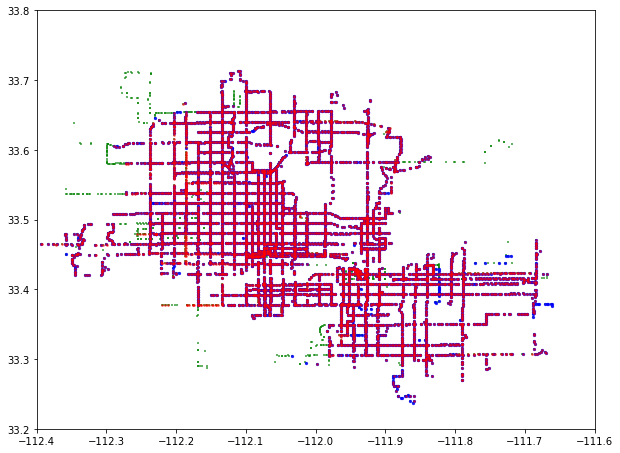

In [254]:
# add stop id geometry
# frequent bus stops using method #1
stop_30_mins_bus_final_1['geometry'] = stop_30_mins_bus_final_1.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_bus_final_1 = gpd.GeoDataFrame(stop_30_mins_bus_final_1)

#frequent bus stops using method #2
stop_30_mins_bus_final_2['geometry'] = stop_30_mins_bus_final_2.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_bus_final_2 = gpd.GeoDataFrame(stop_30_mins_bus_final_2)

loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_bus_final_1.plot(ax=ax, color='blue', marker='o', markersize=5, alpha=0.8)
ax = stop_30_mins_bus_final_2.plot(ax=ax, color='red', marker='o', markersize=3, alpha=0.5)
ax.set_xlim(-112.4, -111.6)
ax.set_ylim(33.2, 33.8)
#ax.set_axis_off()

plt.show()